
--- MNIST CNN Model Summary ---
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten_for_analysis (Flat  (None, 1600)              0         
 ten)                                                            
                       

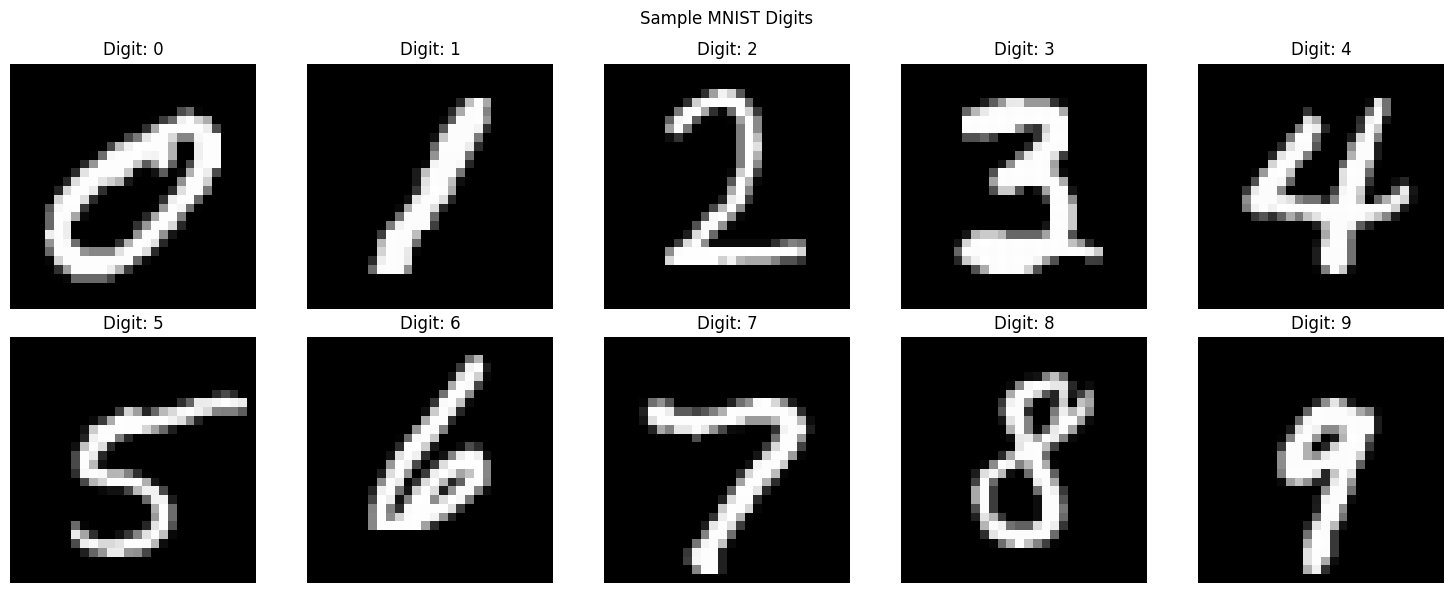

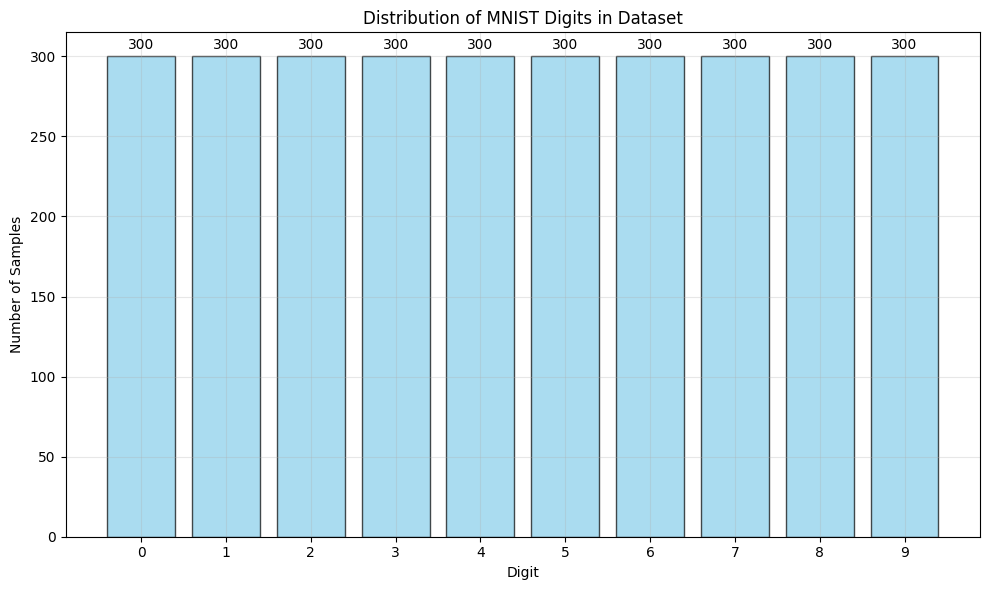


--- Training MNIST Model for 1 Epoch ---
844/844 [==============================] - 15s 17ms/step - loss: 0.1618 - accuracy: 0.9517 - val_loss: 0.0552 - val_accuracy: 0.9850

--- Analyzing Inter-class Variability After 1 Epoch of Training ---
Extracting features from YOUR model's flattened layer (after 1 epoch, from training samples)...
Extracted features shape: (3000, 1600)
Computing inter-class statistics (after 1 epoch)...

Inter-class distances (after 1 epoch, top 10 pairs):
  0-1: 12.00
  6-7: 11.23
  1-3: 10.87
  1-5: 10.81
  0-7: 10.41
  0-4: 10.13
  3-6: 10.03
  1-6: 9.94
  5-7: 9.71
  0-9: 9.61

Intra-class variances (after 1 epoch):
  Digit 0: 0.05
  Digit 1: 0.02
  Digit 2: 0.06
  Digit 3: 0.05
  Digit 4: 0.04
  Digit 5: 0.06
  Digit 6: 0.04
  Digit 7: 0.04
  Digit 8: 0.04
  Digit 9: 0.04

Visualizing feature space with PCA (after 1 epoch)...


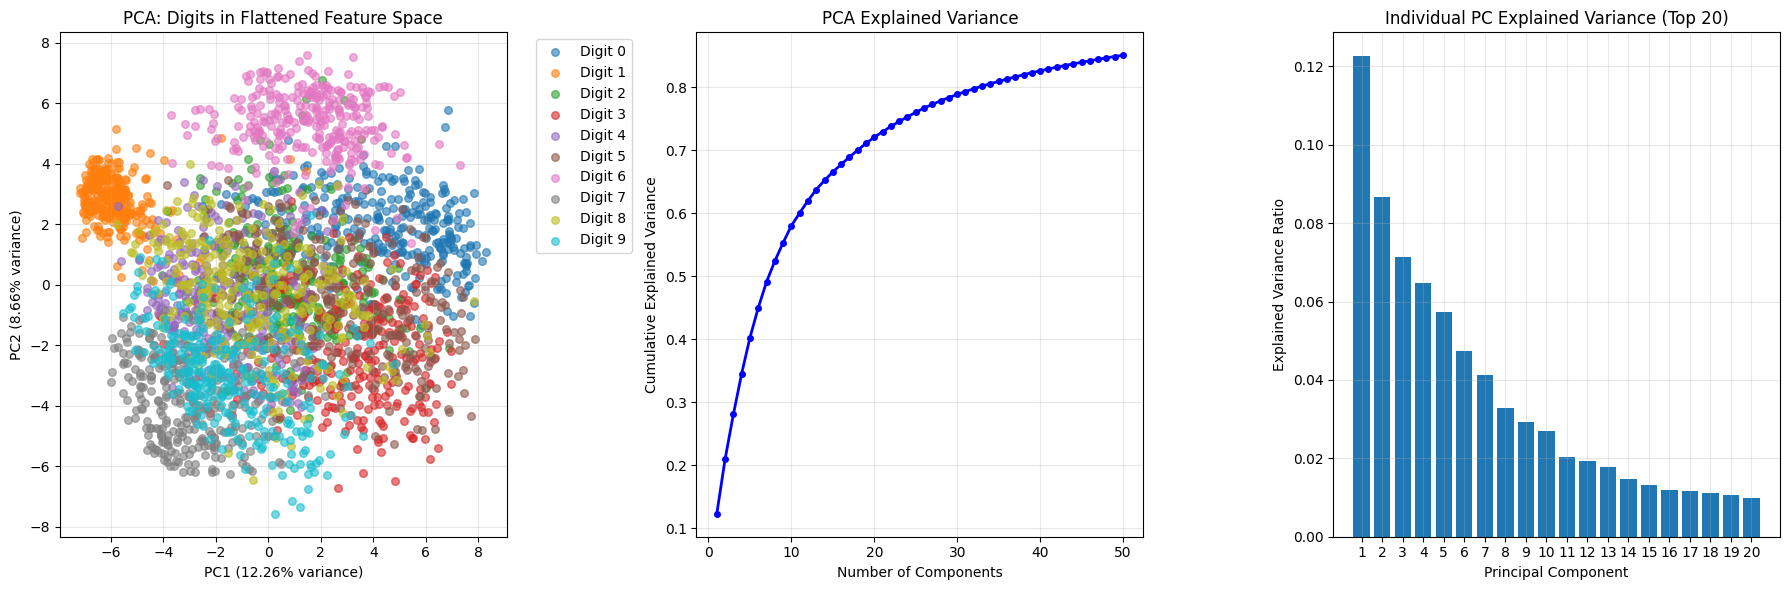

Plotting distance matrices (after 1 epoch)...


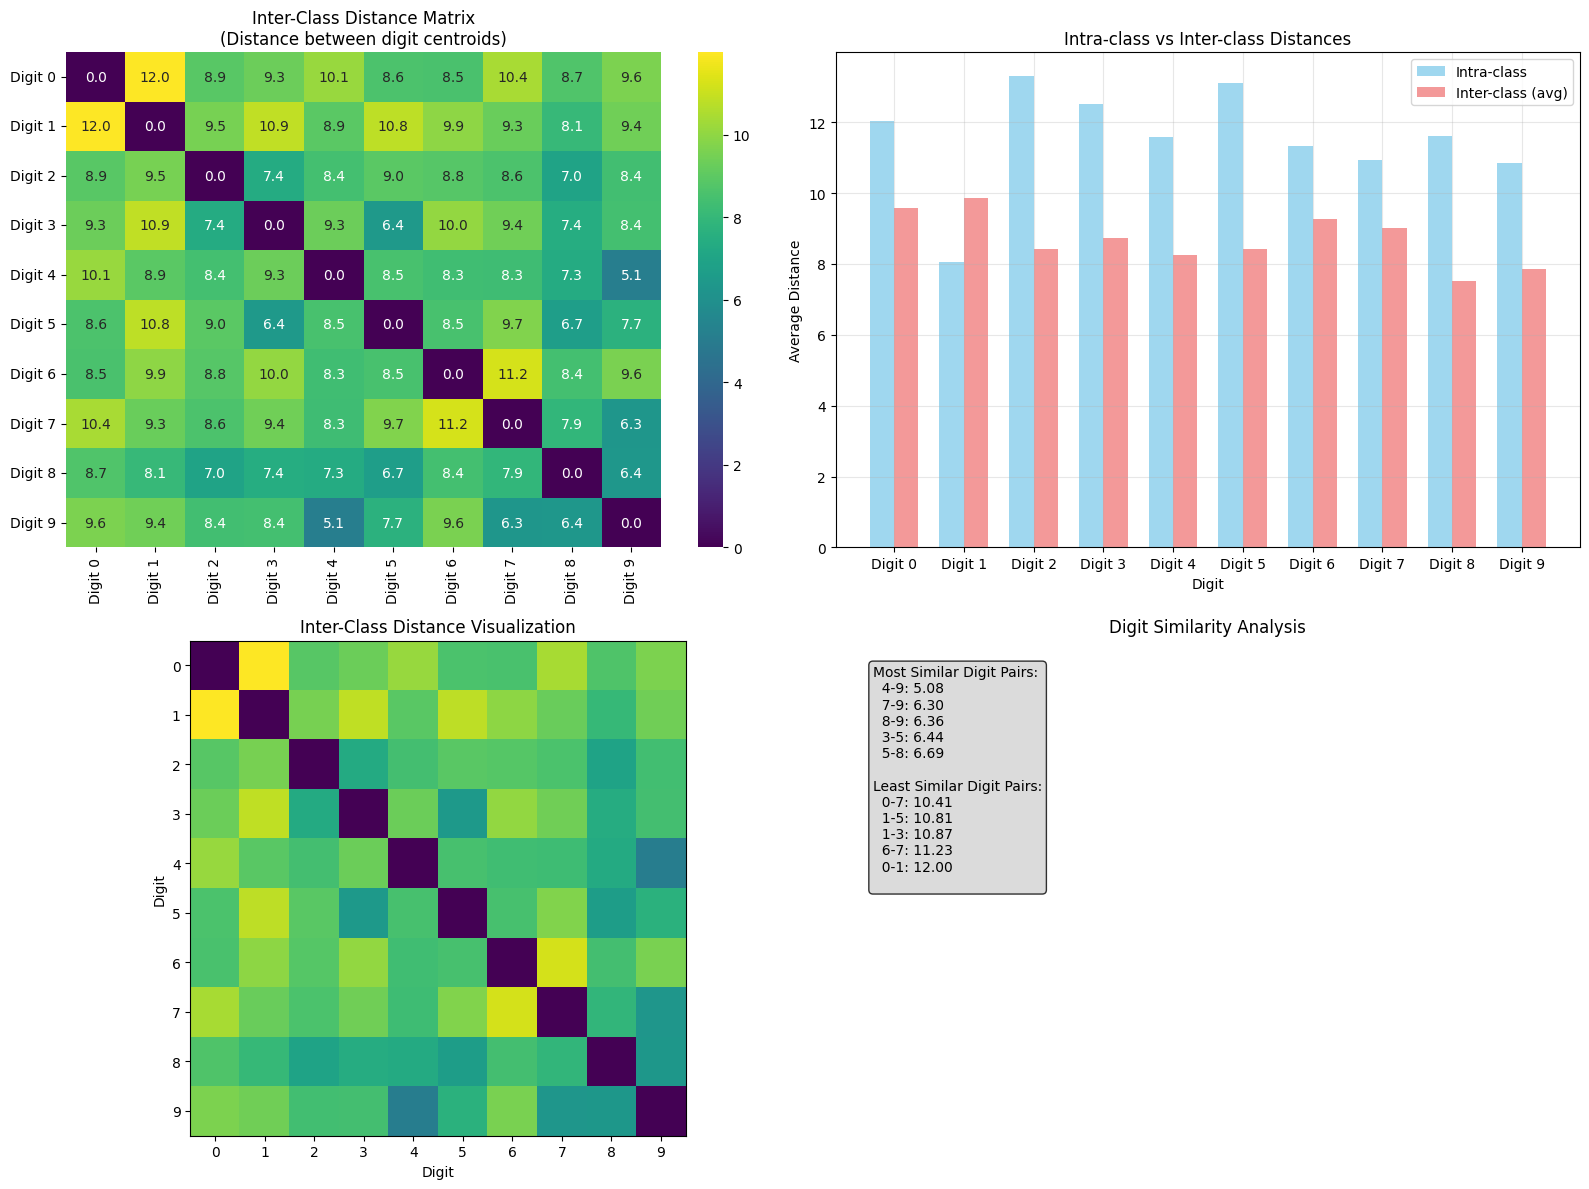

Analyzing feature importance (after 1 epoch)...


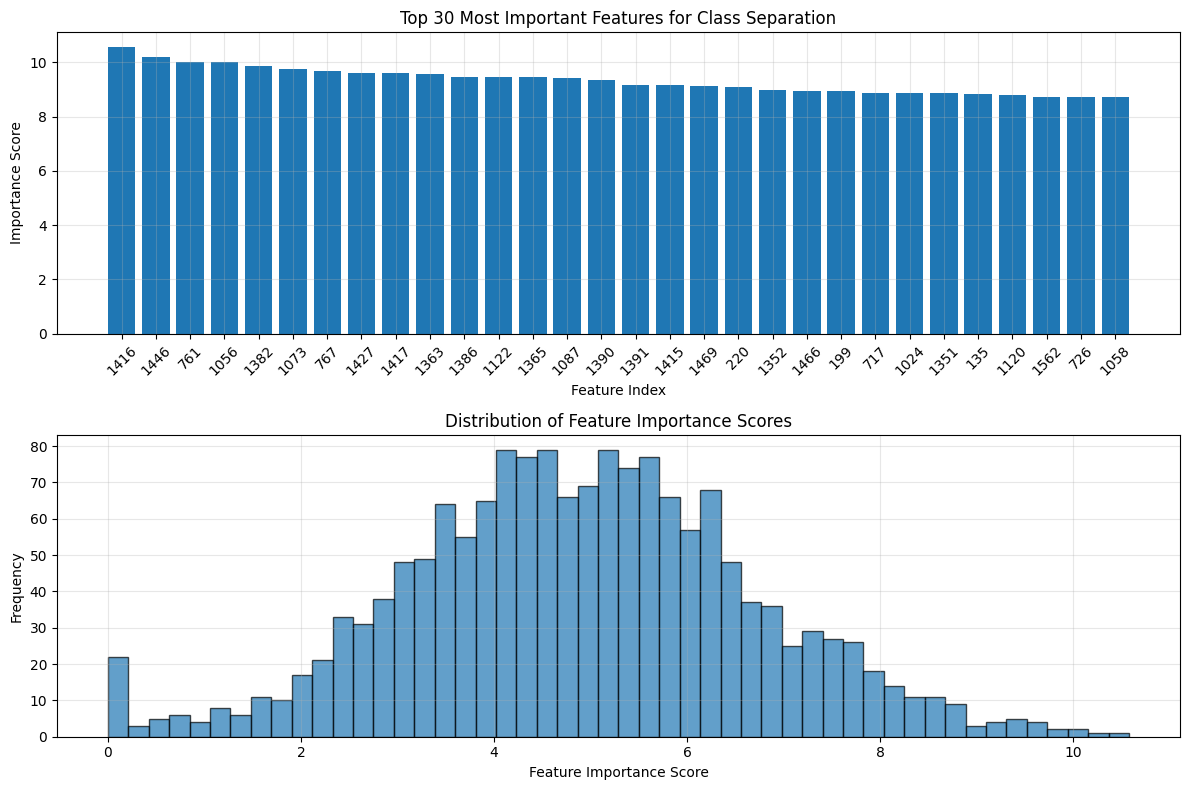


Top 15 most important feature indices (after 1 epoch): [1416 1446  761 1056 1382 1073  767 1427 1417 1363 1386 1122 1365 1087
 1390]

--- Evaluating Model on Test Set ---
Test Loss: 0.0663, Test Accuracy: 0.9799

--- Analyzing Inter-class Variability on Test Set ---
Extracting features from YOUR model's flattened layer (from test samples)...
Extracted features shape (test set): (3000, 1600)
Computing inter-class statistics (test set)...

Inter-class distances (test set, top 10 pairs):
  0-1: 12.40
  6-7: 11.15
  1-5: 10.96
  1-3: 10.95
  0-7: 10.76
  0-4: 10.43
  1-6: 10.16
  3-6: 10.06
  1-9: 9.92
  0-9: 9.91

Intra-class variances (test set):
  Digit 0: 0.05
  Digit 1: 0.02
  Digit 2: 0.06
  Digit 3: 0.05
  Digit 4: 0.04
  Digit 5: 0.06
  Digit 6: 0.04
  Digit 7: 0.04
  Digit 8: 0.04
  Digit 9: 0.04

Visualizing feature space with PCA (test set)...


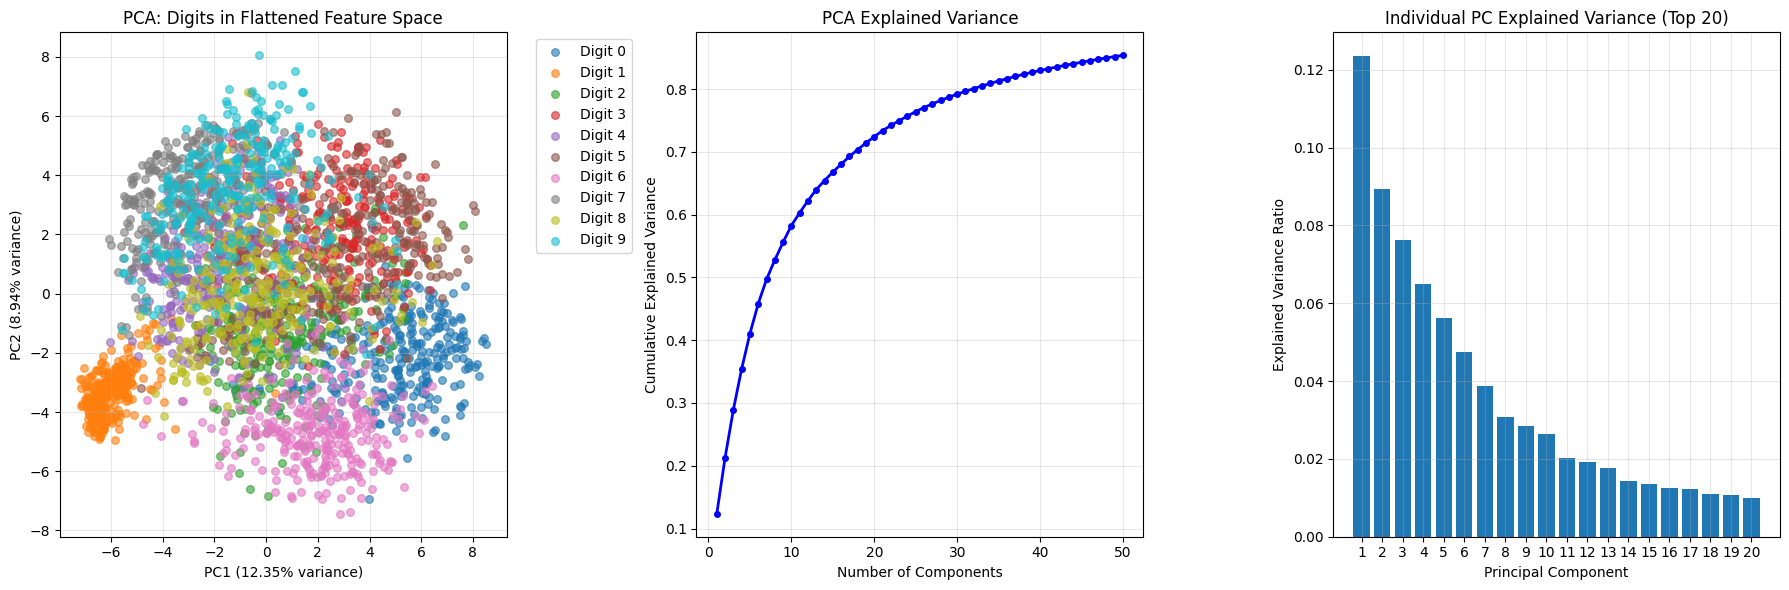

Plotting distance matrices (test set)...


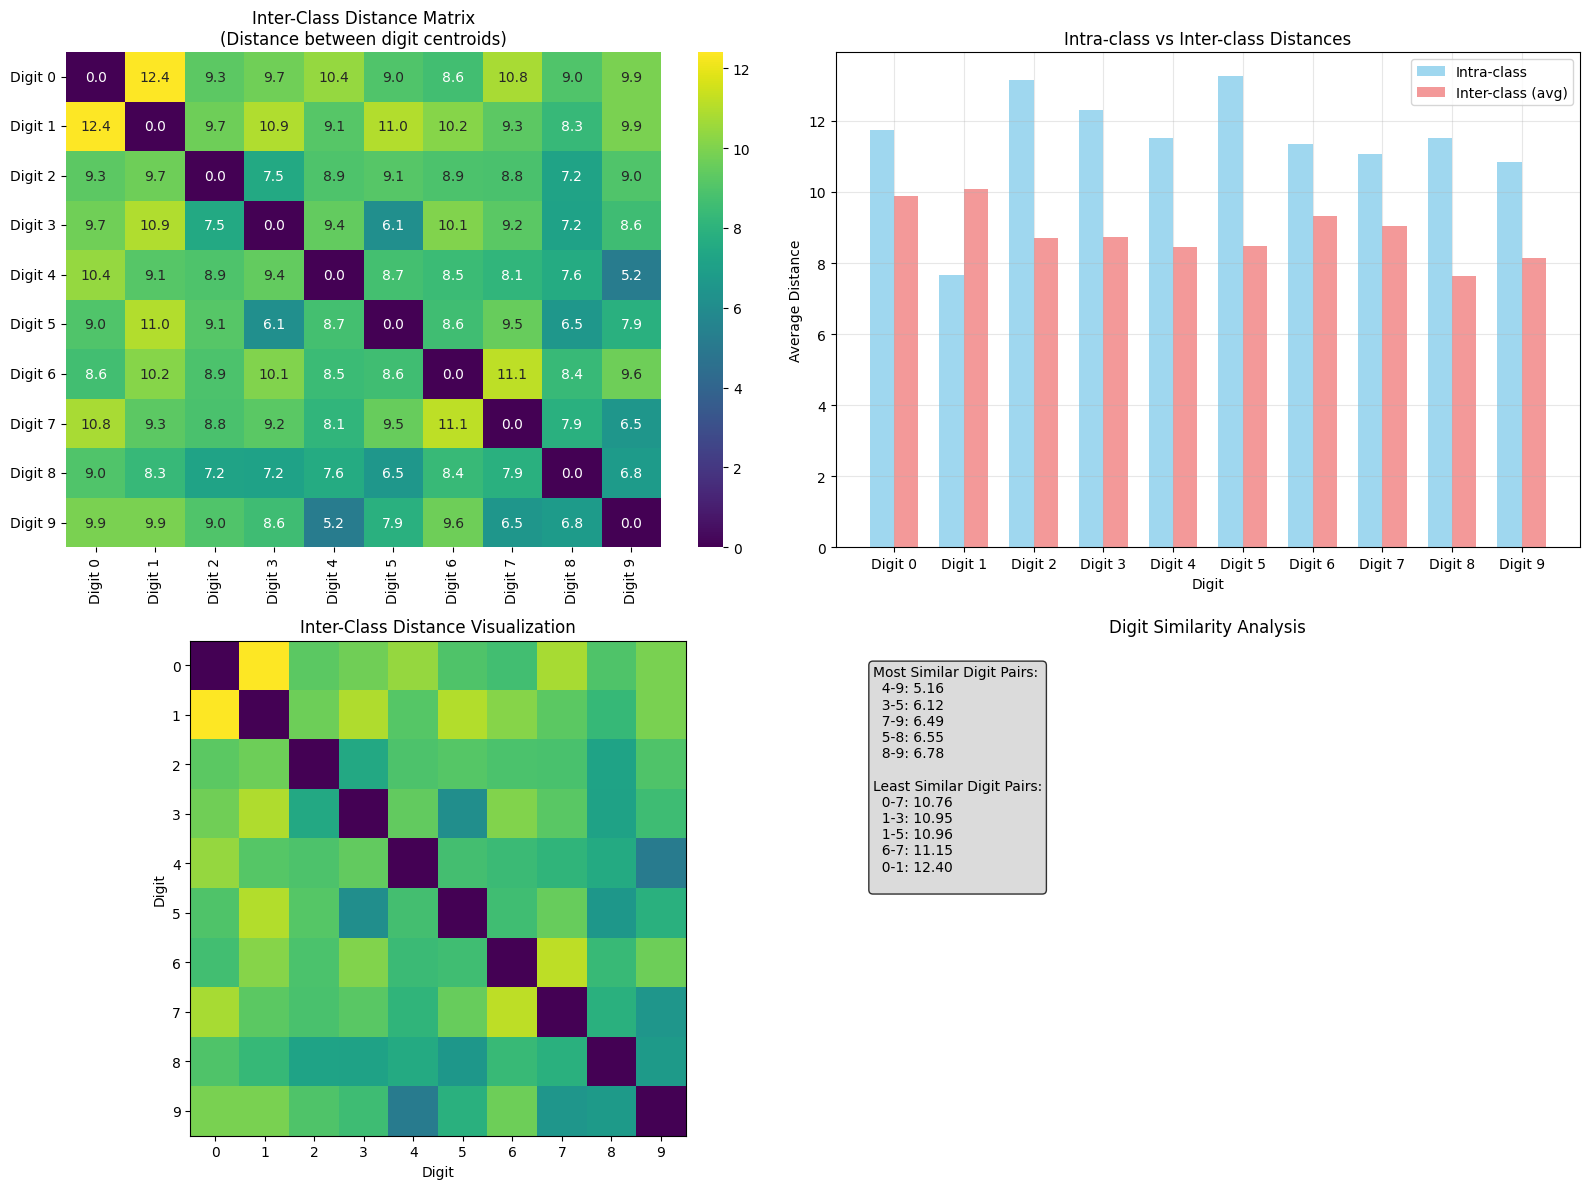

Analyzing feature importance (test set)...


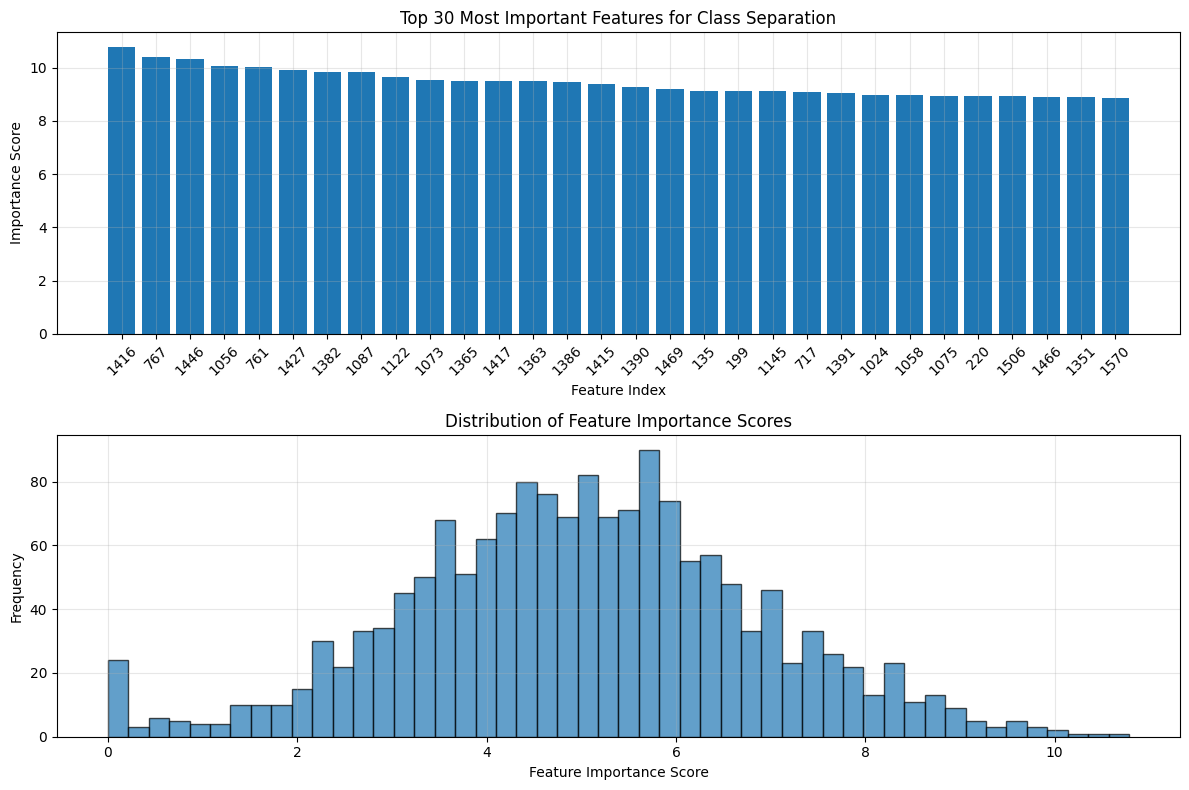


Top 15 most important feature indices (test set): [1416  767 1446 1056  761 1427 1382 1087 1122 1073 1365 1417 1363 1386
 1415]


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
import pandas as pd
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import os

# --- VGG16InterClassVisualizer Class Definition ---
class VGG16InterClassVisualizer:
    def __init__(self):
        """Initialize VGG16 model and extract flattened layer"""
        # Load pre-trained VGG16
        self.base_model = VGG16(weights='imagenet', include_top=True)

        # Create model that outputs flattened layer (before final dense layers)
        # The flattened layer is the output after the last conv block and flatten
        self.feature_extractor = Model(
            inputs=self.base_model.input,
            outputs=self.base_model.get_layer('flatten').output
        )

        print(f"VGG16 Flattened layer shape: {self.feature_extractor.output.shape}")
        print("Note: MNIST images will be preprocessed to match VGG16 input requirements if VGG16 is used directly.")

    def extract_features(self, images, batch_size=32):
        """Extract features from the assigned feature_extractor model"""
        features = []

        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size]
            batch_features = self.feature_extractor.predict(batch, verbose=0)
            features.append(batch_features)

        return np.vstack(features)

    def preprocess_mnist_for_vgg16(self, mnist_images):
        """
        Preprocess MNIST images to work with VGG16
        - Resize from 28x28 to 224x224
        - Convert grayscale to RGB
        - Apply VGG16 preprocessing
        """
        processed_images = []

        for img in mnist_images:
            # Normalize to 0-255 range
            img = (img * 255).astype(np.uint8)

            # Resize to 224x224
            # Add a channel dimension for tf.image.resize if it's not already there (e.g., 28x28 -> 28x28x1)
            if img.ndim == 2:
                img = img[..., np.newaxis]
            img_resized = tf.image.resize(img, [224, 224])

            # Convert grayscale to RGB by repeating the channel
            img_rgb = tf.repeat(img_resized, 3, axis=-1)

            processed_images.append(img_rgb.numpy())

        processed_images = np.array(processed_images)

        # Apply VGG16 preprocessing (mean subtraction, etc.)
        processed_images = preprocess_input(processed_images)

        return processed_images

    def load_mnist_data(self, samples_per_digit=500, test_data=False):
        """
        Load and preprocess MNIST digit dataset for VGG16 analysis.
        This method is primarily for using VGG16 directly.
        For analysis of a custom MNIST model, use that model's expected input format.
        """
        print("Loading MNIST dataset for VGG16 preprocessing...")
        (x_train, y_train), (x_test, y_test) = mnist.load_data()

        # Choose dataset
        if test_data:
            x_data, y_data = x_test, y_test
        else:
            x_data, y_data = x_train, y_train

        # Normalize to 0-1 range (needed before resize/uint8 conversion)
        x_data = x_data.astype('float32') / 255.0

        # Sample data for each digit
        images = []
        labels = []
        digit_classes = list(range(10))  # Digits 0-9

        for digit in digit_classes:
            digit_mask = y_data == digit
            digit_images = x_data[digit_mask]

            # Sample specified number of images per digit
            n_samples = min(samples_per_digit, len(digit_images))
            sampled_indices = np.random.choice(len(digit_images), n_samples, replace=False)
            sampled_images = digit_images[sampled_indices]

            images.extend(sampled_images)
            labels.extend([str(digit)] * n_samples)

        images = np.array(images)

        print(f"Loaded {len(images)} MNIST images (original 28x28).")

        # Preprocess for VGG16
        print("Preprocessing MNIST images for VGG16 input (224x224 RGB)...")
        processed_images = self.preprocess_mnist_for_vgg16(images)

        print(f"Processed shape for VGG16: {processed_images.shape}")

        return processed_images, [str(i) for i in labels], [str(i) for i in digit_classes] # Convert labels to string

    def visualize_sample_digits(self, original_mnist, labels, n_samples=5):
        """Visualize sample MNIST digits from each class"""
        digit_classes = sorted(list(set(labels)))

        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        axes = axes.flatten()

        for i, digit_class in enumerate(digit_classes):
            # Find samples of this digit
            class_indices = [j for j, label in enumerate(labels) if label == digit_class]
            if not class_indices: # Skip if no samples for this digit
                continue
            sample_idx = np.random.choice(class_indices)

            # Show original MNIST image
            axes[i].imshow(original_mnist[sample_idx], cmap='gray')
            axes[i].set_title(f'Digit: {digit_class}')
            axes[i].axis('off')

        plt.suptitle('Sample MNIST Digits')
        plt.tight_layout()
        plt.show()

    def plot_digit_distribution(self, labels):
        """Plot distribution of digits in the dataset"""
        digit_counts = {}
        for label in labels:
            digit_counts[label] = digit_counts.get(label, 0) + 1

        plt.figure(figsize=(10, 6))
        digits = sorted(digit_counts.keys())
        counts = [digit_counts[digit] for digit in digits]

        plt.bar(digits, counts, color='skyblue', edgecolor='black', alpha=0.7)
        plt.xlabel('Digit')
        plt.ylabel('Number of Samples')
        plt.title('Distribution of MNIST Digits in Dataset')
        plt.grid(True, alpha=0.3)

        # Add count labels on bars
        for i, count in enumerate(counts):
            plt.text(i, count + max(counts) * 0.01, str(count),
                     ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    def compute_inter_class_distances(self, features, labels, classes):
        """Compute inter-class distances and statistics"""
        class_centroids = {}
        class_features = {}

        # Compute class centroids
        for class_name in classes:
            class_mask = np.array(labels) == class_name
            class_feat = features[class_mask]
            if len(class_feat) == 0:
                print(f"Warning: No features found for class {class_name}. Skipping centroid computation.")
                continue
            class_features[class_name] = class_feat
            class_centroids[class_name] = np.mean(class_feat, axis=0)

        # Compute inter-class distances
        inter_class_distances = {}
        sorted_classes = sorted(list(class_centroids.keys())) # Ensure consistent order
        for i, class1 in enumerate(sorted_classes):
            for j, class2 in enumerate(sorted_classes):
                if i <= j:
                    if class1 in class_centroids and class2 in class_centroids: # Check if centroids exist
                        dist = np.linalg.norm(
                            class_centroids[class1] - class_centroids[class2]
                        )
                        inter_class_distances[f"{class1}-{class2}"] = dist
                    else:
                        inter_class_distances[f"{class1}-{class2}"] = np.nan # Mark as not computable

        # Compute intra-class variances
        intra_class_variances = {}
        for class_name in classes:
            if class_name in class_centroids: # Only if centroid was computed
                centroid = class_centroids[class_name]
                class_feat = class_features[class_name]
                variances = np.var(class_feat, axis=0)
                intra_class_variances[class_name] = np.mean(variances)
            else:
                intra_class_variances[class_name] = np.nan # Mark as not computable

        return (class_centroids, inter_class_distances,
                intra_class_variances, class_features)

    def visualize_feature_space(self, features, labels, classes, method='pca'):
        """Visualize feature space using PCA or t-SNE"""
        plt.figure(figsize=(18, 6))

        unique_labels = sorted(list(set(labels)))
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
        label_to_color_map = {label: colors[i] for i, label in enumerate(unique_labels)}


        if method.lower() == 'pca':
            # PCA visualization
            pca = PCA(n_components=2)
            features_2d = pca.fit_transform(features)

            plt.subplot(1, 3, 1)

            for i, digit in enumerate(classes):
                mask = np.array(labels) == digit
                if np.any(mask): # Only plot if there are samples for this digit
                    plt.scatter(features_2d[mask, 0], features_2d[mask, 1],
                                c=[label_to_color_map[digit]], label=f'Digit {digit}', alpha=0.6, s=30)

            plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
            plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
            plt.title('PCA: Digits in Flattened Feature Space')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True, alpha=0.3)

            # Explained variance plot
            plt.subplot(1, 3, 2)
            pca_full = PCA()
            pca_full.fit(features)
            cumsum = np.cumsum(pca_full.explained_variance_ratio_)
            plt.plot(range(1, min(51, len(cumsum) + 1)),
                     cumsum[:50], 'bo-', linewidth=2, markersize=4)
            plt.xlabel('Number of Components')
            plt.ylabel('Cumulative Explained Variance')
            plt.title('PCA Explained Variance')
            plt.grid(True, alpha=0.3)

            # First few principal components
            plt.subplot(1, 3, 3)
            plt.bar(range(1, min(21, len(pca_full.explained_variance_ratio_) + 1)),
                   pca_full.explained_variance_ratio_[:20])
            plt.xlabel('Principal Component')
            plt.ylabel('Explained Variance Ratio')
            plt.title('Individual PC Explained Variance (Top 20)')
            plt.xticks(range(1, 21))
            plt.grid(True, alpha=0.3)

        elif method.lower() == 'tsne':
            # t-SNE visualization
            print("Computing t-SNE (this may take a while)...")
            tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
            features_2d = tsne.fit_transform(features)

            plt.subplot(1, 3, 1)

            for i, digit in enumerate(classes):
                mask = np.array(labels) == digit
                if np.any(mask): # Only plot if there are samples for this digit
                    plt.scatter(features_2d[mask, 0], features_2d[mask, 1],
                                c=[label_to_color_map[digit]], label=f'Digit {digit}', alpha=0.6, s=30)

            plt.xlabel('t-SNE Dimension 1')
            plt.ylabel('t-SNE Dimension 2')
            plt.title('t-SNE: Digits in Flattened Feature Space')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        return features_2d

    def plot_distance_matrices(self, features, labels, classes):
        """Plot inter-class and intra-class distance matrices"""
        # Compute pairwise distances between class centroids
        centroids = []
        valid_classes = []
        for digit in classes:
            mask = np.array(labels) == digit
            class_features = features[mask]
            if len(class_features) > 0:
                centroid = np.mean(class_features, axis=0)
                centroids.append(centroid)
                valid_classes.append(digit) # Keep track of classes with data
            else:
                print(f"Warning: No data for class {digit} to compute centroid for distance matrix.")

        centroids = np.array(centroids)
        inter_class_dist_matrix = pairwise_distances(centroids)

        # Compute intra-class distances
        intra_class_distances = []
        for digit in valid_classes: # Use valid_classes for intra-distances too
            mask = np.array(labels) == digit
            class_features = features[mask]
            intra_dist = pairwise_distances(class_features)
            # Ensure intra_dist is not empty before taking mean (e.g., if only 1 sample)
            if intra_dist.size > 0:
                intra_class_distances.append(np.mean(intra_dist))
            else:
                intra_class_distances.append(0) # Or np.nan, depending on desired behavior for single samples


        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # Inter-class distance heatmap
        if len(valid_classes) > 1: # Need at least 2 classes for meaningful heatmap
            sns.heatmap(inter_class_dist_matrix,
                        xticklabels=[f'Digit {d}' for d in valid_classes],
                        yticklabels=[f'Digit {d}' for d in valid_classes],
                        annot=True,
                        fmt='.1f',
                        cmap='viridis',
                        ax=axes[0,0])
            axes[0,0].set_title('Inter-Class Distance Matrix\n(Distance between digit centroids)')
        else:
            axes[0,0].text(0.5, 0.5, "Not enough classes for inter-class heatmap",
                           horizontalalignment='center', verticalalignment='center', transform=axes[0,0].transAxes)
            axes[0,0].set_title('Inter-Class Distance Matrix')
            axes[0,0].axis('off')


        # Intra-class vs Inter-class comparison
        x_pos = np.arange(len(valid_classes))
        width = 0.35

        avg_inter_distances_for_bar = []
        if len(valid_classes) > 0:
            for i in range(len(valid_classes)):
                # Exclude self-distance (which is 0) from average inter-class distance
                other_class_dists = [inter_class_dist_matrix[i, j] for j in range(len(valid_classes)) if i != j]
                if other_class_dists:
                    avg_inter_distances_for_bar.append(np.mean(other_class_dists))
                else:
                    avg_inter_distances_for_bar.append(0) # If only one class, no inter-class dist

        axes[0,1].bar(x_pos - width/2, intra_class_distances, width,
                      label='Intra-class', alpha=0.8, color='skyblue')
        axes[0,1].bar(x_pos + width/2, avg_inter_distances_for_bar,
                      width, label='Inter-class (avg)', alpha=0.8, color='lightcoral')

        axes[0,1].set_xlabel('Digit')
        axes[0,1].set_ylabel('Average Distance')
        axes[0,1].set_title('Intra-class vs Inter-class Distances')
        axes[0,1].set_xticks(x_pos)
        axes[0,1].set_xticklabels([f'Digit {d}' for d in valid_classes])
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)

        # Confusion-like matrix showing most/least similar digit pairs
        axes[1,0].imshow(inter_class_dist_matrix, cmap='viridis')
        axes[1,0].set_title('Inter-Class Distance Visualization')
        axes[1,0].set_xlabel('Digit')
        axes[1,0].set_ylabel('Digit')
        axes[1,0].set_xticks(range(len(valid_classes)))
        axes[1,0].set_yticks(range(len(valid_classes)))
        axes[1,0].set_xticklabels(valid_classes)
        axes[1,0].set_yticklabels(valid_classes)

        # Most and least similar digit pairs
        dist_pairs = []
        for i in range(len(valid_classes)):
            for j in range(i+1, len(valid_classes)):
                dist_pairs.append((valid_classes[i], valid_classes[j], inter_class_dist_matrix[i,j]))

        dist_pairs.sort(key=lambda x: x[2])

        text_info = ""
        if dist_pairs:
            most_similar = dist_pairs[:5]
            least_similar = dist_pairs[-5:]

            text_info += "Most Similar Digit Pairs:\n"
            for d1, d2, dist in most_similar:
                text_info += f"  {d1}-{d2}: {dist:.2f}\n"

            text_info += "\nLeast Similar Digit Pairs:\n"
            for d1, d2, dist in least_similar:
                text_info += f"  {d1}-{d2}: {dist:.2f}\n"
        else:
            text_info = "Not enough pairs to analyze similarity."


        axes[1,1].text(0.05, 0.95, text_info, transform=axes[1,1].transAxes,
                       verticalalignment='top', fontsize=10,
                       bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
        axes[1,1].set_title('Digit Similarity Analysis')
        axes[1,1].axis('off')

        plt.tight_layout()
        plt.show()

        return inter_class_dist_matrix, intra_class_distances

    def analyze_feature_importance(self, features, labels, classes, top_k=20):
        """Analyze which features are most important for class separation"""
        feature_importance = np.zeros(features.shape[1])

        # Filter out classes that might not have any samples
        valid_classes = [c for c in classes if c in labels]

        if not valid_classes:
            print("No valid classes with samples to analyze feature importance.")
            return np.array([]), np.array([])

        for i, class_name in enumerate(valid_classes):
            mask = np.array(labels) == class_name
            class_features = features[mask]
            other_features = features[~mask]

            if len(class_features) == 0 or len(other_features) == 0:
                print(f"Skipping feature importance for class {class_name} due to insufficient samples.")
                continue

            # Compute mean difference for each feature
            class_mean = np.mean(class_features, axis=0)
            other_mean = np.mean(other_features, axis=0)

            # Use absolute difference normalized by standard deviation (Cohen's d like)
            class_std = np.std(class_features, axis=0)
            other_std = np.std(other_features, axis=0)
            pooled_std = np.sqrt((class_std**2 + other_std**2) / 2)

            # Avoid division by zero
            pooled_std = np.maximum(pooled_std, 1e-8)

            importance = np.abs(class_mean - other_mean) / pooled_std
            feature_importance += importance

        if np.all(feature_importance == 0):
            print("Feature importance scores are all zero, likely due to a single class or no variability.")
            return feature_importance, np.array([])

        # Get top features
        top_indices = np.argsort(feature_importance)[-top_k:][::-1]

        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        plt.bar(range(min(top_k, len(top_indices))), feature_importance[top_indices[:top_k]])
        plt.xlabel('Feature Index')
        plt.ylabel('Importance Score')
        plt.title(f'Top {min(top_k, len(top_indices))} Most Important Features for Class Separation')
        plt.xticks(range(min(top_k, len(top_indices))), top_indices[:top_k], rotation=45)
        plt.grid(True, alpha=0.3)

        # Feature importance distribution
        plt.subplot(2, 1, 2)
        plt.hist(feature_importance, bins=50, alpha=0.7, edgecolor='black')
        plt.xlabel('Feature Importance Score')
        plt.ylabel('Frequency')
        plt.title('Distribution of Feature Importance Scores')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        return feature_importance, top_indices

# ---

# MNIST Model Trainer and Analysis

# This class handles training a simple MNIST CNN model and then uses the `VGG16InterClassVisualizer` to analyze the inter-class variability of the features extracted from its flattened layer, both after one epoch of training and on the test set.

# ```python
class MNISTModelTrainer:
    def __init__(self):
        # Initialize your custom MNIST model
        self.model = self._build_mnist_model()
        # Initialize the visualizer, it will initially use VGG16,
        # but we'll temporarily reassign its feature_extractor
        # to our model's flatten layer for analysis.
        self.visualizer = VGG16InterClassVisualizer()

    def _build_mnist_model(self):
        """Builds a simple CNN model for MNIST classification."""
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Flatten(name='flatten_for_analysis'), # Name the flatten layer for easy access
            Dense(128, activation='relu'),
            Dense(10, activation='softmax')
        ])
        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        print("\n--- MNIST CNN Model Summary ---")
        model.summary()
        return model

    def load_and_preprocess_mnist_for_training_and_analysis(self, samples_per_digit=300):
        """
        Loads MNIST data and preprocesses it for both model training/testing
        and for feature analysis (sampling a subset).
        """
        print("Loading MNIST dataset for training and analysis...")
        (x_train, y_train), (x_test, y_test) = mnist.load_data()

        # Preprocess for YOUR MNIST model: normalize and add channel dimension
        x_train_model = x_train.astype('float32') / 255.0
        x_train_model = np.expand_dims(x_train_model, -1) # Add channel dimension for CNN input
        y_train_model = to_categorical(y_train, 10)

        x_test_model = x_test.astype('float32') / 255.0
        x_test_model = np.expand_dims(x_test_model, -1) # Add channel dimension
        y_test_model = to_categorical(y_test, 10)

        # Prepare sampled data for inter-class variability analysis
        # We'll sample 'samples_per_digit' from the training set and test set
        # to keep the analysis consistent and manageable.
        sampled_x_train_for_analysis = []
        sampled_y_train_for_analysis = []
        original_x_train_sampled = [] # For visualize_sample_digits

        sampled_x_test_for_analysis = []
        sampled_y_test_for_analysis = []
        original_x_test_sampled = [] # For visualize_sample_digits

        digit_classes_str = [str(i) for i in range(10)]

        # Sample training data for analysis
        for digit in range(10):
            train_digit_mask = y_train == digit
            train_digit_images = x_train_model[train_digit_mask]
            train_digit_labels = y_train[train_digit_mask]

            n_samples_train = min(samples_per_digit, len(train_digit_images))
            sampled_indices_train = np.random.choice(len(train_digit_images), n_samples_train, replace=False)

            sampled_x_train_for_analysis.extend(train_digit_images[sampled_indices_train])
            sampled_y_train_for_analysis.extend(train_digit_labels[sampled_indices_train])
            original_x_train_sampled.extend(x_train[train_digit_mask][sampled_indices_train]) # Original 28x28 for plotting

            # Sample test data for analysis
            test_digit_mask = y_test == digit
            test_digit_images = x_test_model[test_digit_mask]
            test_digit_labels = y_test[test_digit_mask]

            n_samples_test = min(samples_per_digit, len(test_digit_images)) # Can use same or different sample size
            sampled_indices_test = np.random.choice(len(test_digit_images), n_samples_test, replace=False)

            sampled_x_test_for_analysis.extend(test_digit_images[sampled_indices_test])
            sampled_y_test_for_analysis.extend(test_digit_labels[sampled_indices_test])
            original_x_test_sampled.extend(x_test[test_digit_mask][sampled_indices_test]) # Original 28x28 for plotting


        print(f"Total training samples for analysis: {len(sampled_x_train_for_analysis)}")
        print(f"Total test samples for analysis: {len(sampled_x_test_for_analysis)}")

        return (x_train_model, y_train_model, # Full training set for model.fit
                np.array(sampled_x_train_for_analysis), np.array([str(l) for l in sampled_y_train_for_analysis]), np.array(original_x_train_sampled), # Sampled train for analysis
                x_test_model, y_test_model, # Full test set for model.evaluate
                np.array(sampled_x_test_for_analysis), np.array([str(l) for l in sampled_y_test_for_analysis]), np.array(original_x_test_sampled), # Sampled test for analysis
                digit_classes_str)


    def run_analysis_pipeline(self):
        """
        Executes the training and inter-class variability analysis pipeline.
        """
        (x_train_full, y_train_full,
         x_train_sampled_for_analysis, y_train_sampled_for_analysis, original_x_train_sampled,
         x_test_full, y_test_full,
         x_test_sampled_for_analysis, y_test_sampled_for_analysis, original_x_test_sampled,
         digit_classes) = self.load_and_preprocess_mnist_for_training_and_analysis()

        # --- Initial Data Visualization ---
        print("\n--- Initial Sample Digit Visualization (from training set) ---")
        self.visualizer.visualize_sample_digits(original_x_train_sampled, y_train_sampled_for_analysis)
        self.visualizer.plot_digit_distribution(y_train_sampled_for_analysis)

        # --- Train MNIST Model for 1 Epoch ---
        print("\n--- Training MNIST Model for 1 Epoch ---")
        self.model.fit(x_train_full, y_train_full, epochs=1, batch_size=64, validation_split=0.1, verbose=1)

        # --- Analyze Inter-class Variability After 1 Epoch of Training ---
        print("\n--- Analyzing Inter-class Variability After 1 Epoch of Training ---")

        # Create a feature extractor from your trained MNIST model's specific flatten layer
        # This will be used by the visualizer
        model_feature_extractor = Model(
            inputs=self.model.input,
            outputs=self.model.get_layer('flatten_for_analysis').output
        )
        # Temporarily set the visualizer's feature_extractor to YOUR model's extractor
        self.visualizer.feature_extractor = model_feature_extractor

        print(f"Extracting features from YOUR model's flattened layer (after 1 epoch, from training samples)...")
        # Feed the sampled training data (which is already 28x28x1) directly to your model's extractor
        features_after_epoch1 = self.visualizer.extract_features(x_train_sampled_for_analysis)
        print(f"Extracted features shape: {features_after_epoch1.shape}")

        print("Computing inter-class statistics (after 1 epoch)...")
        centroids_e1, inter_distances_e1, intra_variances_e1, class_features_e1 = \
            self.visualizer.compute_inter_class_distances(features_after_epoch1, y_train_sampled_for_analysis, digit_classes)

        print("\nInter-class distances (after 1 epoch, top 10 pairs):")
        sorted_pairs_e1 = sorted(inter_distances_e1.items(), key=lambda x: x[1], reverse=True)
        for pair, dist in sorted_pairs_e1[:10]:
            print(f"  {pair}: {dist:.2f}")

        print("\nIntra-class variances (after 1 epoch):")
        for digit, var in intra_variances_e1.items():
            print(f"  Digit {digit}: {var:.2f}")

        print("\nVisualizing feature space with PCA (after 1 epoch)...")
        self.visualizer.visualize_feature_space(
            features_after_epoch1, y_train_sampled_for_analysis, digit_classes, method='pca'
        )
        print("Plotting distance matrices (after 1 epoch)...")
        self.visualizer.plot_distance_matrices(
            features_after_epoch1, y_train_sampled_for_analysis, digit_classes
        )
        print("Analyzing feature importance (after 1 epoch)...")
        importance_scores_e1, top_features_e1 = self.visualizer.analyze_feature_importance(
            features_after_epoch1, y_train_sampled_for_analysis, digit_classes, top_k=30
        )
        print(f"\nTop 15 most important feature indices (after 1 epoch): {top_features_e1[:15]}")


        # --- Evaluate Model on Test Set ---
        print("\n--- Evaluating Model on Test Set ---")
        loss, accuracy = self.model.evaluate(x_test_full, y_test_full, verbose=0)
        print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

        # --- Analyze Inter-class Variability During Testing ---
        print("\n--- Analyzing Inter-class Variability on Test Set ---")

        # The visualizer's feature_extractor is already set to our model's flatten layer
        print(f"Extracting features from YOUR model's flattened layer (from test samples)...")
        # Feed the sampled test data (already 28x28x1) directly to your model's extractor
        features_test = self.visualizer.extract_features(x_test_sampled_for_analysis)
        print(f"Extracted features shape (test set): {features_test.shape}")

        print("Computing inter-class statistics (test set)...")
        centroids_test, inter_distances_test, intra_variances_test, class_features_test = \
            self.visualizer.compute_inter_class_distances(features_test, y_test_sampled_for_analysis, digit_classes)

        print("\nInter-class distances (test set, top 10 pairs):")
        sorted_pairs_test = sorted(inter_distances_test.items(), key=lambda x: x[1], reverse=True)
        for pair, dist in sorted_pairs_test[:10]:
            print(f"  {pair}: {dist:.2f}")

        print("\nIntra-class variances (test set):")
        for digit, var in intra_variances_test.items():
            print(f"  Digit {digit}: {var:.2f}")

        print("\nVisualizing feature space with PCA (test set)...")
        self.visualizer.visualize_feature_space(
            features_test, y_test_sampled_for_analysis, digit_classes, method='pca'
        )
        print("Plotting distance matrices (test set)...")
        self.visualizer.plot_distance_matrices(
            features_test, y_test_sampled_for_analysis, digit_classes
        )
        print("Analyzing feature importance (test set)...")
        importance_scores_test, top_features_test = self.visualizer.analyze_feature_importance(
            features_test, y_test_sampled_for_analysis, digit_classes, top_k=30
        )
        print(f"\nTop 15 most important feature indices (test set): {top_features_test[:15]}")

        # Optional: Restore VGG16 feature extractor if you plan to use VGG16 for other tasks later
        # self.visualizer.__init__()


# --- Main Execution Block ---
if __name__ == "__main__":
    # Create an instance of the trainer and run the analysis pipeline
    trainer = MNISTModelTrainer()
    trainer.run_analysis_pipeline()